In [10]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

#Import standard libraries
import numpy as np
import time
import seaborn as sns
import pandas as pd
from itertools import product

from scipy.interpolate import interp1d
from scipy.integrate import simps as simps
from scipy.integrate import cumtrapz as cumtrapz
from scipy.integrate import simps, solve_ivp
from scipy.constants import c as c_light #meters/seconds
from scipy.stats.distributions import chi2 as chi2_dist

c_light_km = c_light/1000 #km/s

import getdist
getdist.chains.print_load_details = False

# import repo functions:
import sys, os
import os
import git
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_data = os.path.join(os.path.dirname(path_git), 'GILA-output', 'paper')
path_figures = os.path.join(path_git, 'notebooks', 'figures')

os.chdir(os.path.join(path_git, 'fr_mcmc', 'utils'))
from supernovae import aparent_magnitude_th, chi2_supernovae
from constants import OMEGA_R_0, LAMBDA, L, KAPPA

In [11]:

def F_H(H, params, model):     
    lamb, L, beta, L_bar, r, s = params # L and L_bar have to be in units of H0^{-1}
    if model == 'GILA':
        lamb = 0; p = 3; q = 1
        FH = H**2 - beta * H**(2*r) * L_bar**(2*(r-1)) * np.exp(-beta*(L_bar*H)**(2*s)) #\
                  #+ lamb * H**(2*p) * L**(2*(p-1))     * np.exp(lamb*(L*H)**(2*q))

    elif model == 'BETA':
        lamb = 0; p = 1; q = 2; r = 1
        FH = H**2 - beta * H**2                        * np.exp(-beta*(L_bar*H)**(2*s)) #\
                  #+ lamb * H**(2*p) * L**(2*(p-1))     * np.exp(lamb*(L*H)**(2*q))

    return FH


def F_H_prime(H, params, model):
    lamb, L, beta, L_bar, r, s = params # L and L_bar have to be in units of H0^{-1}
   
    if model == 'GILA':
        lamb = 0; p = 3; q = 1
        aux = beta * np.exp(-beta*(L_bar*H)**(2*s)) * (L_bar*H)**(2*(r-1)) * (-r + s * beta * (L_bar*H)**(2*s)) #+\
              #lamb * np.exp(lamb*(L*H)**(2*q))      * (L*H)**(2*(p-1))     * (p  + q * lamb * (L*H)**(2*q))

    elif model == 'BETA':
        lamb = 0; p = 1; q = 2; r = 1
        aux = beta * np.exp(-beta*(L_bar*H)**(2*s))                        * (-1 + s * beta * (L_bar*H)**(2*s)) #+\
              #lamb * np.exp(lamb*(L*H)**(2*q))      * (L*H)**(2*(p-1)) * (p  + q * lamb * (L*H)**(2*q))

    FH_prime = 2 * H * (1 + aux) 
    return FH_prime


def get_odes(z, Hubble, params_ode, lcdm=False):
    '''
    Returns the system of ODEs for the given cosmological model.


    Parameters:
    -----------
    z : float
        Redshift value.
    variables : list
        List of values for the dynamical variables.
    physical_params : list
        List of model parameters, where the first n-1 elements are the model parameters,
        while the last one specifies the cosmological model. Mathematically, this information is contained in
        the function Gamma.
    model : str, optional
        Cosmological model that is being integrated. Defaults to 'LCDM'.

    Returns:
    -----------
    list
        Set of ODEs for the dynamical variables.
    '''    
    [LAMBDA, L, b, L_bar, H_0, r, s, model] = params_ode #Here L and L_bar are in units of H0^{-1}

    F_H0 = F_H(H_0, [LAMBDA, L, b, L_bar, r, s], model)

    omega_m_0 = F_H0 /(100**2) - OMEGA_R_0

    rho_m_0 = 100**2 * omega_m_0 / KAPPA
    rho_r_0 = 100**2 * OMEGA_R_0 / KAPPA
    
    rho_r = rho_r_0 * (1+z)**4
    rho_m = rho_m_0 * (1+z)**3
    rho_tot =  rho_r + rho_m 
    p_tot =  (1/3) * rho_r

    # To integrate in z
    s =  3 * KAPPA * (rho_tot + p_tot/c_light_km**2) / ((1+z)*F_H_prime(Hubble, [LAMBDA, L, b, L_bar, r, s], model))     
    #print(s)
    return s


def integrator_GILA(physical_params, model, num_z_points=int(10**5),
                initial_z=0, final_z=3,
                system_equations=get_odes, verbose=False,
                method='RK45', rtol=1e-11, atol=1e-16):
 
    t1 = time.time()
    #L_bar, b, H0 = physical_params
    L_bar, b, H0, r, s = physical_params
    
    #Cambiar si pasamos de logspace a linspace!
    zs_int = np.linspace(initial_z, final_z, num_z_points)
    
    #ode_params = [LAMBDA, L/H0, b, L_bar/H0, H0, model]
    ode_params = [LAMBDA, L/H0, b, L_bar/H0, H0, r, s, model]
    sol = solve_ivp(system_equations, (initial_z,final_z),
                    [H0], t_eval=zs_int, args = [ode_params],
                    rtol=rtol, atol=atol, method=method)
        

    assert len(sol.t)==num_z_points, 'Something is wrong with the integration!'
    assert np.all(zs_int==sol.t), 'Not all the values of z coincide with the ones that were required!'

    # Calculate the Hubble parameter
    zs_final = sol.t
    Hs_final = sol.y[0]

    t2 = time.time()

    if verbose == True:
        print('Duration: {} minutes and {} seconds'.format(int((t2-t1)/60),
                int((t2-t1) - 60*int((t2-t1)/60))))

    return zs_final, Hs_final

In [12]:
def delta_chi2_threshold(confidence_level, num_parameters):
    delta_chi2_threshold = chi2_dist.ppf(confidence_level, num_parameters)
    return delta_chi2_threshold


def chi2_without_cov(teo, data, errors_cuad):
    '''
    Calculate chi square assuming no correlation.

    teo (array): Theoretical prediction of the model.
    data (array): Observational data to compare with the model.
    errors_cuad (array): The square of the errors of the data.

    '''

    chi2 = np.sum((data-teo)**2/errors_cuad)
    return chi2

def params_to_chi2(theta, model, dataset_CC=None,dataset_SN_plus_shoes=None,
                   num_z_points=int(10**5)):

    #chi2_SN = 0
    #chi2_CC = 0
    
    [Mabs, L_bar, b, H_0, r, s] = theta
    physical_params = [L_bar, b, H_0, r, s]
    try:
        zs_model, Hs_model = integrator_GILA(physical_params, model=model, num_z_points=num_z_points,
                                            initial_z=0, final_z=10)
    except Exception as e:
        # If integration fails, reject the step
        return -np.inf

    Hs_interp = interp1d(zs_model, Hs_model)

    int_inv_Hs = cumtrapz(Hs_model**(-1), zs_model, initial=0)
    int_inv_Hs_interp = interp1d(zs_model, int_inv_Hs)

    if dataset_CC != None:
        z_data, H_data, dH = dataset_CC #Import the data
        H_teo = Hs_interp(z_data)
        chi2_CC = chi2_without_cov(H_teo, H_data, dH**2)

    if dataset_SN_plus_shoes != None:
        zhd, zhel, mb, mu_shoes, Cinv, is_cal = dataset_SN_plus_shoes #Import the data
        muobs = mb - Mabs
        muth_num = aparent_magnitude_th(int_inv_Hs_interp, zhd, zhel) #Numeric prediction of mu
        muth = muth_num*(-is_cal + 1) + mu_shoes*(is_cal) #Merge num predicion with mu_shoes
        chi2_SN = chi2_supernovae(muth, muobs, Cinv)


    return chi2_SN + chi2_CC

path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
os.chdir(path_git); os.sys.path.append('./fr_mcmc/utils/')
from data import read_data_chronometers, read_data_pantheon_plus_shoes

# Cosmic Chronometers
os.chdir(path_git+'/fr_mcmc/source/CC/')
ds_CC = read_data_chronometers('chronometers_data.txt')

# Pantheon plus + SH0ES
os.chdir(path_git+'/fr_mcmc/source/Pantheon_plus_shoes')
ds_SN_plus_shoes = read_data_pantheon_plus_shoes('Pantheon+SH0ES.dat',
                                'Pantheon+SH0ES_STAT+SYS.cov')


First, let's fix some parameters

In [13]:
#Fix params
L_bar = 0.90

Gyr_to_second = int(3.1536e16)
Mpc_to_km = int(3.0857e19)
inv_Hub_to_Gyr = Mpc_to_km/Gyr_to_second


z = np.linspace(0, 1000, int(10e3))
aou_threshold = 12.7

num_free_parameters = 3
dof = ds_SN_plus_shoes[2].shape[0]+len(ds_CC[0]) - num_free_parameters

confidence_level = 0.683 #1 sigma contour
#confidence_level = 0.954 #2 sigma contour
#confidence_level = 0.997 #3 sigma contour


In [70]:
import numpy as np
from scipy.stats import chi2

def chi2_threshold(N, p, confidence=0.95):
    """
    Compute the chi-square threshold for model rejection based on a given confidence level.
    
    Parameters:
    N (int): Number of data points
    p (int): Number of parameters
    confidence (float): Confidence level (e.g., 0.95 for 95%)
    
    Returns:
    float: Reduced chi-square threshold
    """
    nu = N - p  # Degrees of freedom
    chi2_crit = chi2.ppf(confidence, df=nu)  # Critical chi-square value
    return chi2_crit / nu  # Convert to reduced chi-square

# Example usage
N = ds_SN_plus_shoes[2].shape[0]+len(ds_CC[0])
p = 3
confidence_level = 0.683  # 95% confidence threshold

threshold = chi2_threshold(N, p, confidence_level)
print(f"Reduced chi-square threshold for {confidence_level*100}% confidence: {threshold:.5f}")
print(1+np.sqrt(2/(N-p)))


Reduced chi-square threshold for 68.30000000000001% confidence: 1.01610
1.0344622758397788


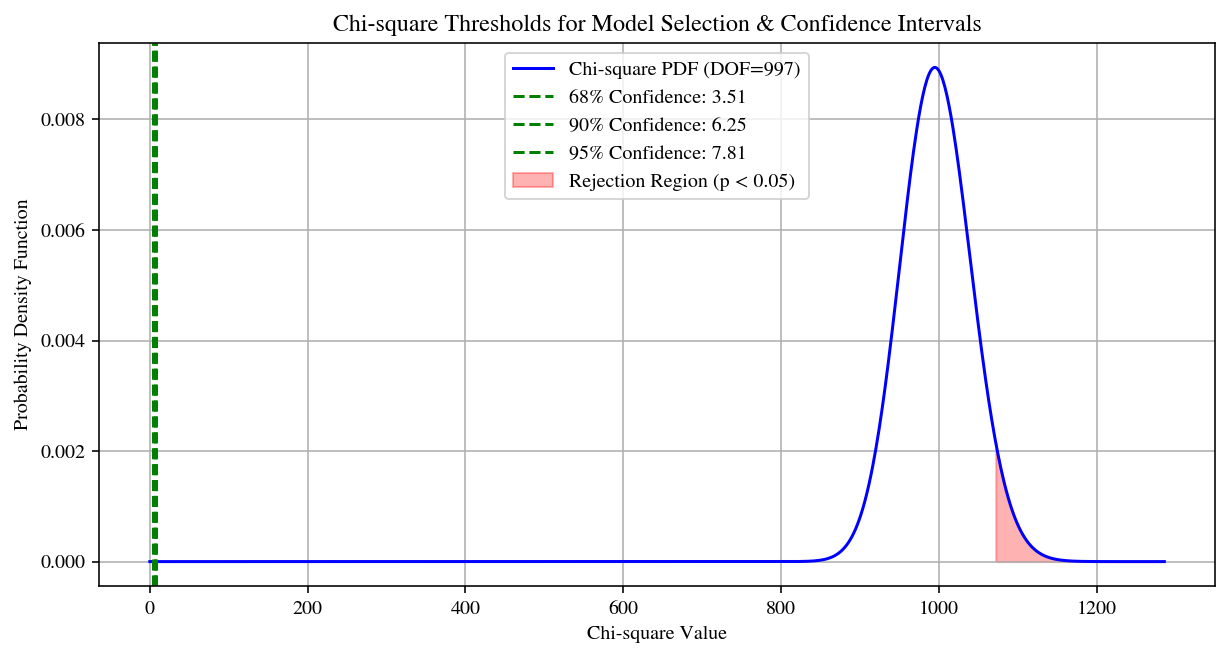

In [71]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Define parameters
N = 1000  # Number of data points
p = 3     # Number of free parameters

# Degrees of freedom
dof_fit = N - p
dof_wilks = p

# Compute thresholds
alpha_fit = 0.05  # 95% confidence for goodness of fit
chi2_fit_threshold = stats.chi2.ppf(1 - alpha_fit, dof_fit)

alpha_wilks = {"68%": 1 - 0.68, "90%": 1 - 0.90, "95%": 1 - 0.95}
chi2_wilks_thresholds = {key: stats.chi2.ppf(1 - val, dof_wilks) for key, val in alpha_wilks.items()}

# Generate chi-square distribution
x_fit = np.linspace(0, chi2_fit_threshold * 1.2, 1000)
y_fit = stats.chi2.pdf(x_fit, dof_fit)

x_wilks = np.linspace(0, max(chi2_wilks_thresholds.values()) * 1.2, 1000)
y_wilks = stats.chi2.pdf(x_wilks, dof_wilks)

# Plot goodness-of-fit chi-square distribution
plt.figure(figsize=(10, 5))
plt.plot(x_fit, y_fit, label=f"Chi-square PDF (DOF={dof_fit})", color='blue')

# Shade the rejection region
plt.fill_between(x_fit, y_fit, where=(x_fit >= chi2_fit_threshold), color='red', alpha=0.3, label="Rejection Region (p < 0.05)")

# Plot Wilks' theorem chi-square thresholds
for level, threshold in chi2_wilks_thresholds.items():
    plt.axvline(threshold, color='green', linestyle='--', label=f"{level} Confidence: {threshold:.2f}")

# Labels and legend
plt.xlabel("Chi-square Value")
plt.ylabel("Probability Density Function")
plt.title("Chi-square Thresholds for Model Selection & Confidence Intervals")
plt.legend()
plt.grid()

# Show plot
plt.show()


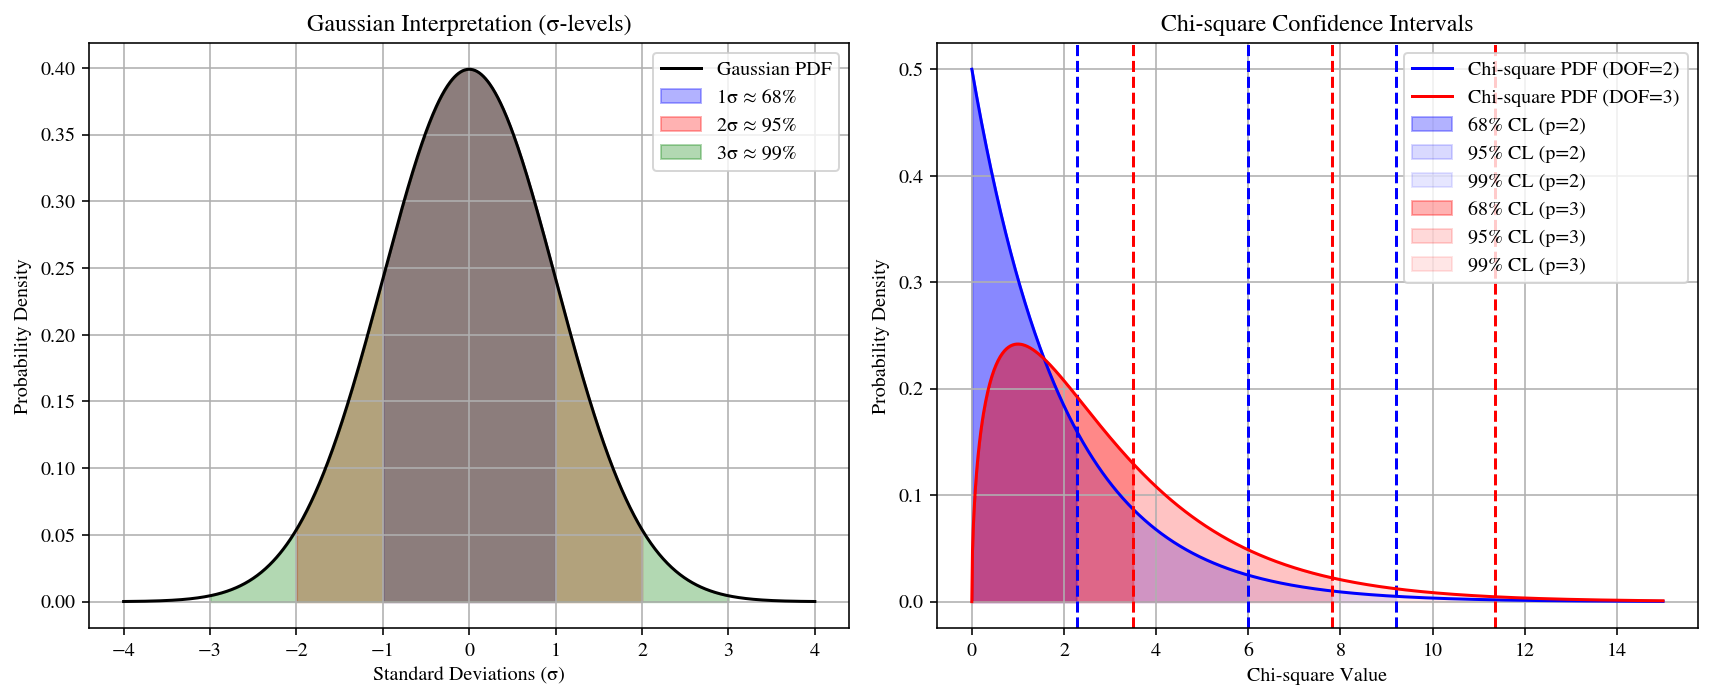

In [72]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Gaussian x-axis (standard normal)
x_gauss = np.linspace(-4, 4, 1000)
y_gauss = stats.norm.pdf(x_gauss, 0, 1)

# Chi-square x-axis
x_chi = np.linspace(0, 15, 1000)

# Define p = 2 and p = 3 degrees of freedom
dof_values = [2, 3]
colors = ["blue", "red"]

# Compute chi-square confidence thresholds
confidence_levels = [0.68, 0.95, 0.99]
thresholds = {p: [stats.chi2.ppf(cl, p) for cl in confidence_levels] for p in dof_values}

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Left Plot: Gaussian Distribution (σ-intervals) ---
axes[0].plot(x_gauss, y_gauss, label="Gaussian PDF", color="black")
axes[0].fill_between(x_gauss, y_gauss, where=(np.abs(x_gauss) <= 1), color='blue', alpha=0.3, label="1σ ≈ 68%")
axes[0].fill_between(x_gauss, y_gauss, where=(np.abs(x_gauss) <= 2), color='red', alpha=0.3, label="2σ ≈ 95%")
axes[0].fill_between(x_gauss, y_gauss, where=(np.abs(x_gauss) <= 3), color='green', alpha=0.3, label="3σ ≈ 99%")

axes[0].set_title("Gaussian Interpretation (σ-levels)")
axes[0].set_xlabel("Standard Deviations (σ)")
axes[0].set_ylabel("Probability Density")
axes[0].legend()
axes[0].grid()

# --- Right Plot: Chi-square Confidence Levels ---
for i, p in enumerate(dof_values):
    y_chi = stats.chi2.pdf(x_chi, p)
    axes[1].plot(x_chi, y_chi, label=f"Chi-square PDF (DOF={p})", color=colors[i])
    
    # Shade confidence levels
    for j, cl in enumerate(confidence_levels):
        axes[1].fill_between(x_chi, y_chi, where=(x_chi <= thresholds[p][j]), color=colors[i], alpha=0.3/(j+1), label=f"{int(cl*100)}% CL (p={p})")
    
    # Vertical lines for chi-square thresholds
    for t in thresholds[p]:
        axes[1].axvline(t, color=colors[i], linestyle="dashed")

axes[1].set_title("Chi-square Confidence Intervals")
axes[1].set_xlabel("Chi-square Value")
axes[1].set_ylabel("Probability Density")
axes[1].legend()
axes[1].grid()

# Show plot
plt.tight_layout()
plt.show()


In [66]:
from scipy.stats import norm
chi2_crit = norm.ppf(0.01,loc=13.32, scale=np.sqrt(0.5**2+0.1**2))  # Critical chi-square value
print(chi2_crit)
chi2_crit = norm.cdf(12.7,loc=13.32, scale=np.sqrt(0.5**2+0.1**2))  # Critical chi-square value
print(chi2_crit)


chi2_crit = norm.cdf(13.32,loc=13.32, scale=np.sqrt(0.5**2+0.1**2))  # Critical chi-square value
print(chi2_crit)
chi2_crit = norm.ppf(0.5,loc=13.32, scale=np.sqrt(0.5**2+0.1**2))  # Critical chi-square value
print(chi2_crit)

12.133790679486067
0.11200769204430572
0.5
13.32


# GILA model analysis

In [5]:
#GILA MODEL
#r_min = 3
#s_min = 1

r = 3; s = 1
H0_values = np.linspace(60,80,10)[::-1] 
beta_values = np.linspace(0.1,12,10)
Mabs_values = np.linspace(-21,-18.5,10)

#r = 8; s = 1 #Does not work :(
#H0_values = np.linspace(60,80,20)[::-1] 
#beta_values = np.linspace(0.1,12,20)
#Mabs_values = np.linspace(-21,-18.5,20)

#r = 3; s = 2 #It works, not with AoU
#H0_values = np.linspace(60,80,20)[::-1] 
#beta_values = np.linspace(0.1,12,20)
#Mabs_values = np.linspace(-21,-18.5,20)

#r = 3; s = 4 #It works, not with AoU
#H0_values = np.linspace(60,80,20)[::-1] 
#beta_values = np.linspace(0.1,12,20)
#Mabs_values = np.linspace(-21,-18.5,20)

#r = 3; s = 5 #It worked, even with AoU!
#H0_values = np.linspace(60,80,20)[::-1] 
#beta_values = np.linspace(0.1,12,20)
#Mabs_values = np.linspace(-21,-18.5,20)

#r = 3; s = 6 #It worked, even with AoU!
#H0_values = np.linspace(60,80,20)[::-1] 
#beta_values = np.linspace(0.1,12,20)
#Mabs_values = np.linspace(-21,-18.5,20)

print(H0_values, beta_values, Mabs_values)

matrix_gila_chi2 = np.zeros((len(H0_values), len(beta_values),len(Mabs_values)))
mask_aou = np.zeros((len(H0_values), len(beta_values),len(Mabs_values)))
mask_1_sigma = np.zeros((len(H0_values), len(beta_values),len(Mabs_values)))

for (i, (H0_val, beta_val, Mabs_val)) in enumerate(product(H0_values, beta_values, Mabs_values)):
    physical_params = [L_bar, beta_val, H0_val, r, s]
    try :        
        z_final, Hs_final = integrator_GILA(physical_params, model='GILA', num_z_points=int(len(z)),
                                        initial_z=z[0], final_z=z[-1])
    except Exception as e:
        # If integration fails
        matrix_gila_chi2.flat[i] = np.nan
        continue

    theta = [Mabs_val, L_bar, beta_val, H0_val, r, s]
    chi2 = params_to_chi2(theta, dataset_SN_plus_shoes=ds_SN_plus_shoes, dataset_CC=ds_CC, model='GILA') #/ dof
    
    matrix_gila_chi2.flat[i] = chi2 / dof
    
    #if chi2 <= dof + np.sqrt(2*dof): #change condition with respect to the older notebook
    #    mask_1_sigma.flat[i] = 1

    aou_gila = inv_Hub_to_Gyr * simps(((1+z_final) * Hs_final)**(-1), z_final)
    if aou_gila >= aou_threshold: #change condition with respect to the older notebook
        mask_aou.flat[i] = 1



[80.         77.77777778 75.55555556 73.33333333 71.11111111 68.88888889
 66.66666667 64.44444444 62.22222222 60.        ] [ 0.1         1.42222222  2.74444444  4.06666667  5.38888889  6.71111111
  8.03333333  9.35555556 10.67777778 12.        ] [-21.         -20.72222222 -20.44444444 -20.16666667 -19.88888889
 -19.61111111 -19.33333333 -19.05555556 -18.77777778 -18.5       ]


In [6]:
mask_1_sigma =  matrix_gila_chi2 - np.nanmin(matrix_gila_chi2) <= delta_chi2_threshold(confidence_level, num_free_parameters)

In [7]:
print(matrix_gila_chi2)

[[[         nan          nan          nan          nan          nan
            nan          nan          nan          nan          nan]
  [202.64040852 154.48991718 112.92738624  77.95281569  49.56620553
    27.76755577  12.55686641   3.93413743   1.89936886   6.45256067]
  [184.6283558  138.7929843   99.5455732   66.88612249  40.81463218
    21.33110226   8.43553274   2.12792361   2.40827488   9.27658654]
  [185.38857247 139.46915574 100.1376994   67.39420345  41.2386679
    21.67109275   8.69147798   2.29982362   2.49612964   9.28039606]
  [187.9673938  141.72033982 102.06124624  68.99011305  42.50694026
    22.61172786   9.30447586   2.58518425   2.45385304   8.91048222]
  [189.78796332 143.30851251 103.41702209  70.11349207  43.39792245
    23.27031322   9.73066438   2.77897594   2.41524789   8.63948024]
  [190.76425308 144.15995572 104.14361875  70.71524217  43.87482599
    23.6223702    9.95787481   2.88133981   2.39276521   8.492151  ]
  [191.2256275  144.56222493 104.48678275 

In [8]:
print(r'Minimum of the reduced $\chi^2$:{}'.format(np.nanmin(matrix_gila_chi2)))

Minimum of the reduced $\chi^2$:1.1944602104646342


In [9]:
masked_data_with_aou = np.where(mask_aou == 1, matrix_gila_chi2, np.nan)
masked_data_with_1_sigma = np.where(mask_1_sigma == 1, matrix_gila_chi2, np.nan)
masked_data_with_aou_1_sigma = np.where(mask_1_sigma == 1, masked_data_with_aou, np.nan)

print(masked_data_with_aou)
print(masked_data_with_1_sigma)
print(masked_data_with_aou_1_sigma)

[[[nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]]

 [[nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]]

 [[nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan n

In [10]:
where_global_min = np.where(matrix_gila_chi2==np.nanmin(matrix_gila_chi2))
matrix_gila_chi2[where_global_min]

array([1.19446021])

## 2D proyection

In [11]:
print(r'The global minima corresponds to M abs={0}'.format(Mabs_values[where_global_min[2][0]]))
matrix_gila_chi2_2d = matrix_gila_chi2[:,:,where_global_min[2][0]]
masked_data_with_aou_2d = masked_data_with_aou[:,:,where_global_min[2][0]]
masked_data_with_1_sigma_2d = masked_data_with_1_sigma[:,:,where_global_min[2][0]]
masked_data_with_aou_1_sigma_2d = masked_data_with_aou_1_sigma[:,:,where_global_min[2][0]]

The global minima corresponds to M abs=-19.333333333333332


/home/mleize/miniconda3/envs/fR-MCMC/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: All-NaN slice encountered
  after removing the cwd from sys.path.
/home/mleize/miniconda3/envs/fR-MCMC/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: All-NaN slice encountered
  """
/home/mleize/miniconda3/envs/fR-MCMC/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


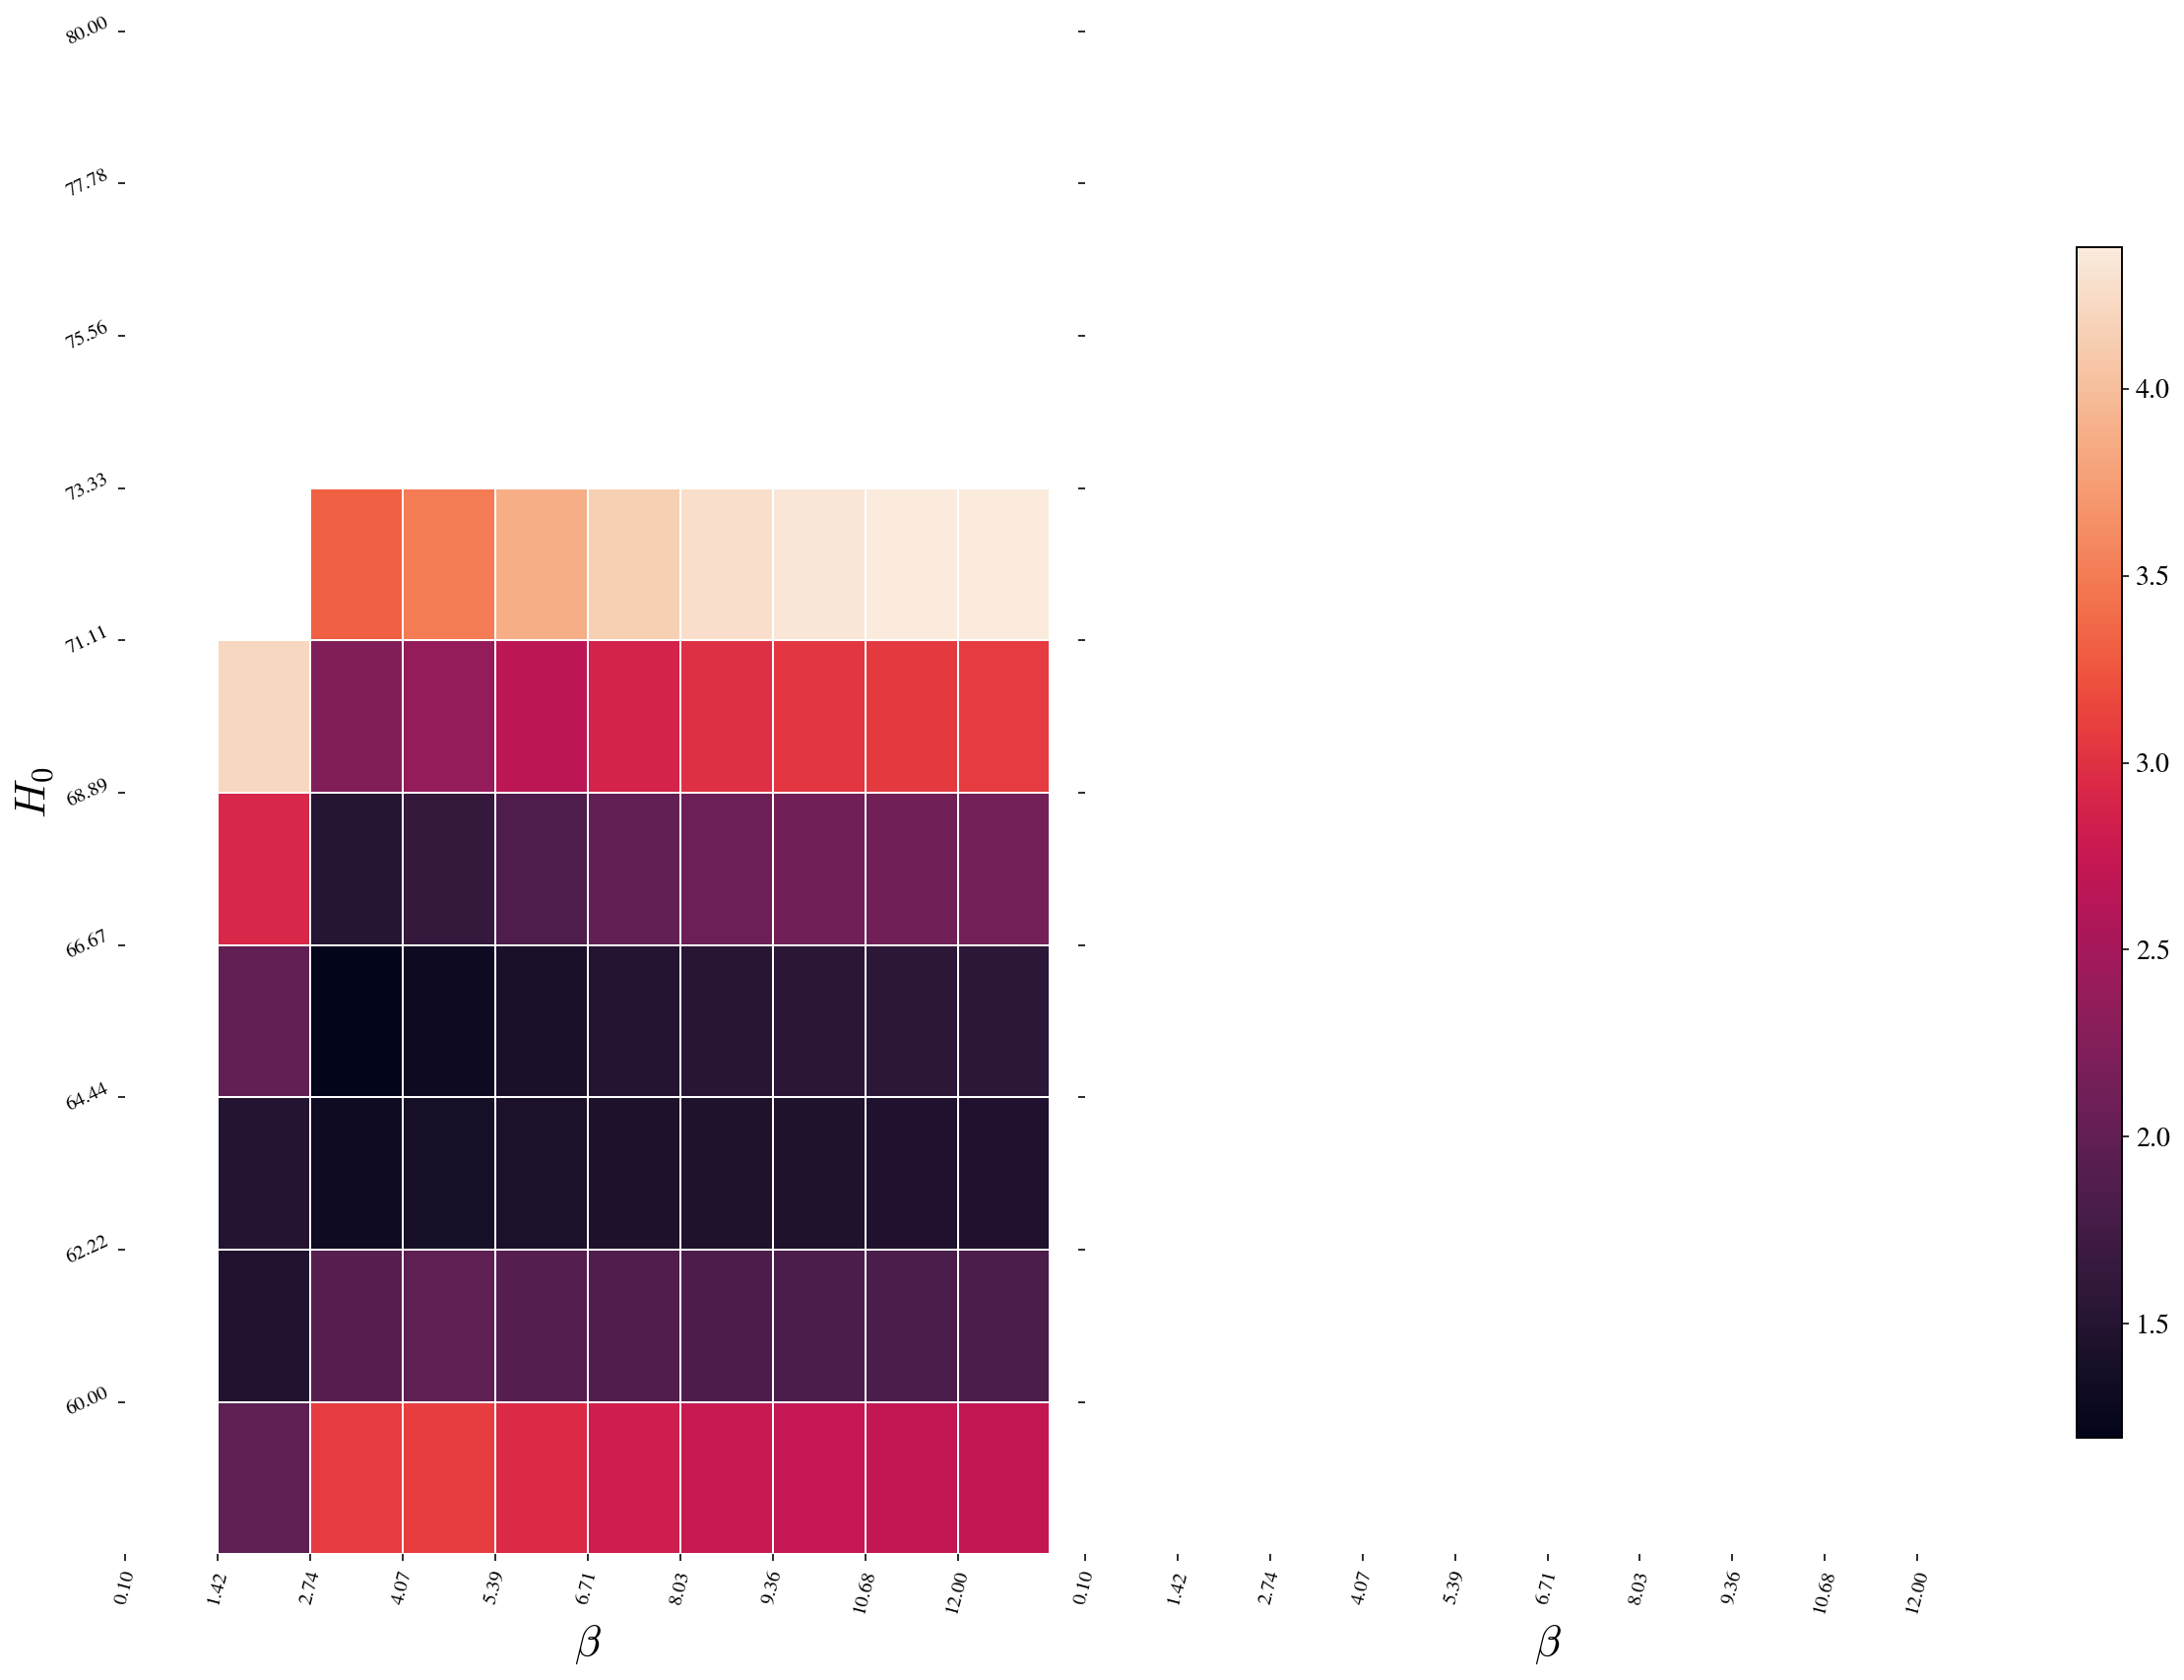

In [12]:
# Plot GILA model
fig, axes = plt.subplots(1,2,figsize=(16, 12))
# Define common color scale
vmin = min(np.nanmin(masked_data_with_1_sigma_2d), np.nanmin(masked_data_with_aou_1_sigma_2d))
vmax = max(np.nanmax(masked_data_with_1_sigma_2d), np.nanmax(masked_data_with_aou_1_sigma_2d))

# Plot heatmaps without colorbars
sns.heatmap(masked_data_with_1_sigma_2d, ax=axes[0], linewidth=0.5, vmin=vmin, vmax=vmax, cbar=False)
sns.heatmap(masked_data_with_aou_1_sigma_2d, ax=axes[1], linewidth=0.5, vmin=vmin, vmax=vmax, cbar=False)

# General configurations for all axes
for ax in axes.flat:
    ax.set_xlabel(r'$\beta$', fontsize=22)
    ax.set_ylabel(r'$H_0$', fontsize=22)
    ax.set_xticks(np.arange(len(beta_values)))
    ax.set_yticks(np.arange(len(H0_values)))
    ax.set_xticklabels([f'{tick:.2f}' for tick in beta_values],rotation = 75)
    ax.set_yticklabels([f'{tick:.2f}' for tick in H0_values],rotation = 25)
    ax.label_outer()

# Add a single colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust position as needed
cbar = fig.colorbar(axes[0].collections[0], cax=cbar_ax)  # Use one of the heatmap's color mappings

# Change colorbar tick label size
cbar.ax.tick_params(labelsize=14)  # Set fontsize

fig.colorbar(axes[0].collections[0], cax=cbar_ax)  # Use one of the heatmap's color mappings

fig.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit the colorbar


fig.savefig(os.path.join(path_figures, 'heat_map_aou_GILA_r={0}_s={1}_Lbar={2}.png'.format(r,s,L_bar)))
fig.savefig(os.path.join(path_figures, 'heat_map_aou_GILA_r={0}_s={1}_Lbar={2}.pdf'.format(r,s,L_bar)))
plt.show()



# Final Questions